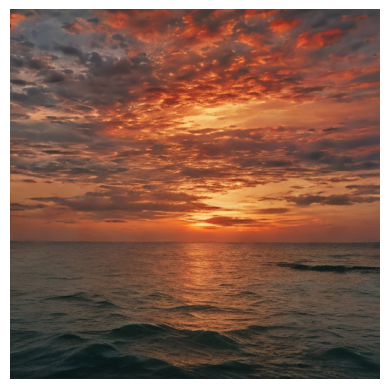

Terminating the loop gracefully.


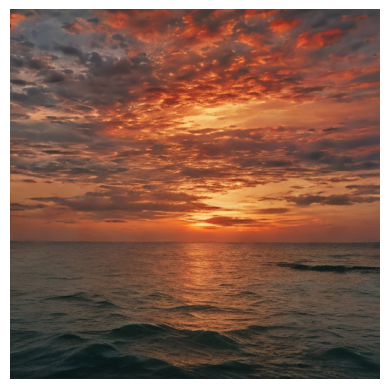

In [1]:
import torch
import threading
from diffusers import AutoPipelineForText2Image
from diffusers import DDIMScheduler
from diffusers_local import UNet2DConditionModel as UNet2DConditionModel_local
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from NetworkBending import NetworkBending
import time  # for safely terminating the loop

# Create a global lock for synchronizing OSC parameter updates
osc_lock = threading.Lock()

# Instantiate NetworkBending object
NB = NetworkBending()

# Start the OSC server in a background thread
osc_thread = threading.Thread(target=NB.serve_forever)
osc_thread.daemon = True  # Ensure the OSC thread terminates when the program ends
osc_thread.start()

# Initialize the pipeline
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sd-turbo", torch_dtype=torch.float32, variant="fp16", )
pipe.unet = UNet2DConditionModel_local.from_pretrained("stabilityai/sd-turbo", subfolder="unet", torch_dtype=torch.float32, variant="fp16", network_bending=NB)
pipe.to("cuda")

pipe.scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
    prediction_type="epsilon",
    num_train_timesteps=1000,
    timestep_spacing="trailing",
    trained_betas=None
)

pipe.set_progress_bar_config(disable=True)

#print(pipe.scheduler)
#print(pipe.unet)

# Main loop for image generation
try:
    while True:
        with osc_lock:  # Ensure that network bending is thread-safe
            output = pipe("a beautiful sunset over the ocean", 
                          generator=torch.Generator(device="cpu").manual_seed(42), 
                          guidance_scale=0.4, 
                          num_inference_steps=1,
                          width=512,
                          height=512
                          )
        
        image = output.images[0]
        clear_output(wait=True)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        display(plt.gcf())
        #time.sleep(0.1)  # Add a small sleep to prevent overwhelming CPU

except KeyboardInterrupt:
    NB.stop()
    print("Terminating the loop gracefully.")
    
